In [0]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [0]:
#get shareable link from your csv file in gdrive
link = 'https://drive.google.com/open?id=1MmZS962wr2KQI2vEQbAWiEJ3exkYuso4'
_, id = link.split("=")

downloaded = drive.CreateFile({'id':id}) 
downloaded.GetContentFile('kaggle.json')  

In [0]:
!mkdir ~/.kaggle
!cp kaggle.json ~/.kaggle/kaggle.json

In [4]:
!kaggle competitions download -c grasp-and-lift-eeg-detection

 99% 910M/915M [00:07<00:00, 135MB/s]
100% 915M/915M [00:07<00:00, 123MB/s]
  0% 0.00/5.16M [00:00<?, ?B/s]
100% 5.16M/5.16M [00:00<00:00, 85.0MB/s]
 88% 134M/153M [00:01<00:00, 116MB/s] 
100% 153M/153M [00:01<00:00, 137MB/s]


In [0]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
from torch.autograd import Variable
import torch.nn.functional as F
from torch.nn.utils import weight_norm
import random
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score as auc
from scipy.interpolate import BSpline

In [6]:
!unzip train.zip
!unzip test.zip


Archive:  train.zip
   creating: train/
  inflating: train/subj10_series1_data.csv  
  inflating: train/subj10_series1_events.csv  
  inflating: train/subj10_series2_data.csv  
  inflating: train/subj10_series2_events.csv  
  inflating: train/subj10_series3_data.csv  
  inflating: train/subj10_series3_events.csv  
  inflating: train/subj10_series4_data.csv  
  inflating: train/subj10_series4_events.csv  
  inflating: train/subj10_series5_data.csv  
  inflating: train/subj10_series5_events.csv  
  inflating: train/subj10_series6_data.csv  
  inflating: train/subj10_series6_events.csv  
  inflating: train/subj10_series7_data.csv  
  inflating: train/subj10_series7_events.csv  
  inflating: train/subj10_series8_data.csv  
  inflating: train/subj10_series8_events.csv  
  inflating: train/subj11_series1_data.csv  
  inflating: train/subj11_series1_events.csv  
  inflating: train/subj11_series2_data.csv  
  inflating: train/subj11_series2_events.csv  
  inflating: train/subj11_series3_data.c

In [0]:
USE_CUDA = 1

In [0]:
PATH = ''
data = pd.read_csv(f'{PATH}train/subj1_series1_data.csv')
ev = pd.read_csv(f'{PATH}train/subj1_series1_events.csv')

In [0]:
labels=ev.columns[1:]

In [0]:
class eegdata(Dataset):
    
    def __init__(self, path, validation=False,test=False,subjects=range(1,13)):
        super().__init__()
        data, self.target = self.readfiles(path, validation,test, subjects)
        self.mean= data.mean(axis=0)
        self.std = data.std(axis=0)
        self.data = self.norm(data)
    
    def norm(self, x):
        return ((x - self.mean)/self.std)
    
    def to_np(self, values):
        
        #get total lines of data count
        count = 0
        for i in range(len(values)):
            count += len(values[i])
        
        #create np array size of all data
        ret = np.zeros((count, len(values[0][0])))
        
        #copy data into np array 
        ix = 0
        for i in range(len(values)):
            ret[ix:ix+len(values[i]), :] = values[i]
            ix += len(values[i])
        return ret
        
    
    def readfiles(self, path, validation,test, subjects):
        
        allx = []
        ally = []
        if validation == False and test==False:
          series = [1,2,5,6]
        elif validation==True and test==False:
          series=[3,4]
        else :
          series=[7,8]
        
        for i in subjects:
            print('log: reading subject {}...'.format(i))
            xs = None
            ys = None
            for j in series:

                data = 'subj{}_series{}_data.csv'.format(i,j)
                events = 'subj{}_series{}_events.csv'.format(i,j)

                x = pd.read_csv(path + data).values[:, 1:]
                xs = x if xs is None else np.vstack((xs, x))

                y = pd.read_csv(path + events).values[:, 1:]
                ys = y if ys is None else np.vstack((ys, y))

            allx.append(xs)
            ally.append(ys)

        xs = self.to_np(allx)
        ys = self.to_np(ally)
        print(xs.shape)
        return xs, ys
                    
    
    def __getitem__(self, index):
        return self.data[index], self.target[index]
        
    def __len__(self):
        return len(self.data)

In [23]:
su=[1,2]
traindata = eegdata(f'{PATH}train/', subjects=su)

log: reading subject 1...
log: reading subject 2...
(1831469, 32)


In [11]:
subjects=range(1,13)
traindata = eegdata(f'{PATH}train/', subjects=subjects)
valdata = eegdata(f'{PATH}train/', subjects=subjects, validation=True)
test=eegdata(f'{PATH}train/', subjects=subjects, test=True)

log: reading subject 1...
log: reading subject 2...
log: reading subject 3...
log: reading subject 4...
log: reading subject 5...
log: reading subject 6...
log: reading subject 7...
log: reading subject 8...
log: reading subject 9...
log: reading subject 10...
log: reading subject 11...
log: reading subject 12...
log: reading subject 1...
log: reading subject 2...
log: reading subject 3...
log: reading subject 4...
log: reading subject 5...
log: reading subject 6...
log: reading subject 7...
log: reading subject 8...
log: reading subject 9...
log: reading subject 10...
log: reading subject 11...
log: reading subject 12...
log: reading subject 1...
log: reading subject 2...
log: reading subject 3...
log: reading subject 4...
log: reading subject 5...
log: reading subject 6...
log: reading subject 7...
log: reading subject 8...
log: reading subject 9...
log: reading subject 10...
log: reading subject 11...
log: reading subject 12...


In [0]:
# some parameteres for the model
num_features = 32
window_size = 1024
batch_size=2000

In [0]:
# Batch creator. When training it will return random locations in the dataset. The data is a time series 
# and so we feed previous readings (going back window_size) in with each index. Rather than feed in all window_size 
# previous readings, we subsample and take every 4th set of readings.

def get_batch(dataset, batch_size=2000, val=False, index=None):
    
    if val == False:
        index = random.randint(window_size, len(dataset) - 16 * batch_size)
        indexes = np.arange(index, index + 16*batch_size, 16)

    else:
        indexes = np.arange(index, index + batch_size)
    
    batch = np.zeros((batch_size, num_features, window_size//4))
    
    b = 0
    for i in indexes:
        
        start = i - window_size if i - window_size > 0 else 0
        
        tmp = dataset.data[start:i]
        batch[b,:,:] = tmp[::4].transpose()
        
        b += 1

    targets = dataset.target[indexes]
    return torch.DoubleTensor(batch), torch.DoubleTensor(targets) 

In [0]:
class convmodel(nn.Module):
    
    def __init__(self, out_classes, drop=0.5, d_linear=124):
        super().__init__()
        
        self.conv = nn.Conv1d(32, 64, kernel_size=3, padding=0, stride=1)
        self.conv2 = nn.Conv1d(64, 128, kernel_size=3, padding=0, stride=1)
        self.conv3 = nn.Conv1d(128, 256, kernel_size=3, padding=0, stride=1)
        self.bn = nn.BatchNorm1d(64)
        self.pool = nn.MaxPool1d(2, stride=2)
        self.linear1 = nn.Linear(16256, d_linear)
        self.linear3 = nn.Linear(d_linear, out_classes)
        self.dropout1 = nn.Dropout(drop)
        self.dropout2 = nn.Dropout(drop)
        self.dropout3 = nn.Dropout(drop)
        self.convo = nn.Sequential(self.conv, nn.ReLU(inplace=True), self.conv2,\
                                    nn.ReLU(inplace=True), self.conv3, nn.ReLU(inplace=True), self.bn,self.pool, self.dropout1)
        
        
        self.dense = nn.Sequential(self.linear1, nn.ReLU(inplace=True),self.dropout2,\
                                    self.dropout3, self.linear3)
        
    def forward(self, x):
        bs = x.size(0)
        x = self.conv(x)
        x = x.view(bs, -1)
        output = self.dense(x)
        
        
        return torch.sigmoid(output)

In [66]:
model = convmodel(6).double()
if USE_CUDA == 1:
    model = model.cuda()
optim = torch.optim.Adam(model.parameters(), lr=1e-3, eps=1e-10)
from torch.nn.modules.module import _addindent
def torch_summarize(model, show_weights=True, show_parameters=True):
    """Summarizes torch model by showing trainable parameters and weights."""
    tmpstr = model.__class__.__name__ + ' (\n'
    for key, module in model._modules.items():
        # if it contains layers let call it recursively to get params and weights
        if type(module) in [
            torch.nn.modules.container.Container,
            torch.nn.modules.container.Sequential
        ]:
            modstr = torch_summarize(module)
        else:
            modstr = module.__repr__()
        modstr = _addindent(modstr, 2)

        params = sum([np.prod(p.size()) for p in module.parameters()])
        weights = tuple([tuple(p.size()) for p in module.parameters()])

        tmpstr += '  (' + key + '): ' + modstr 
        if show_weights:
            tmpstr += ', weights={}'.format(weights)
        if show_parameters:
            tmpstr +=  ', parameters={}'.format(params)
        tmpstr += '\n'   

    tmpstr = tmpstr + ')'
    return tmpstr

print(torch_summarize(model))

convmodel (
  (conv): Conv1d(32, 64, kernel_size=(3,), stride=(1,)), weights=((64, 32, 3), (64,)), parameters=6208
  (conv2): Conv1d(64, 128, kernel_size=(3,), stride=(1,)), weights=((128, 64, 3), (128,)), parameters=24704
  (conv3): Conv1d(128, 256, kernel_size=(3,), stride=(1,)), weights=((256, 128, 3), (256,)), parameters=98560
  (bn): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True), weights=((64,), (64,)), parameters=128
  (pool): MaxPool1d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False), weights=(), parameters=0
  (linear1): Linear(in_features=16256, out_features=124, bias=True), weights=((124, 16256), (124,)), parameters=2015868
  (linear3): Linear(in_features=124, out_features=6, bias=True), weights=((6, 124), (6,)), parameters=750
  (dropout1): Dropout(p=0.5, inplace=False), weights=(), parameters=0
  (dropout2): Dropout(p=0.5, inplace=False), weights=(), parameters=0
  (dropout3): Dropout(p=0.5, inplace=False), weights=(), param

In [0]:
from torchsummary import summary
bs = batch_size

def train(traindata, epochs, printevery=100, shuffle=True):
    model.train()
    for epoch in range(epochs):
        total_loss = 0
        for i in range(len(traindata)//bs):
            optim.zero_grad()
            x, y = get_batch(traindata)
            #print(x.shape)
            if USE_CUDA == 1:
                x = Variable(x).cuda()
                y = Variable(y).cuda()
                print(x.shape)
            preds = model(x)
            #summary(model, (64, 32, 3), batch_size=2000) 
            loss = F.binary_cross_entropy(preds.view(-1), y.view(-1))
            loss.backward()
            total_loss += loss.item()
            optim.step()
            if (i + 1) % printevery == 0:
                print("epoch: %d, iter %d/%d, loss %.4f"%(epoch + 1, i + 1, len(traindata)//2000, total_loss/printevery))
                total_loss = 0

In [59]:
train(traindata,1)

torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])
torch.Size([2000, 32, 256])


KeyboardInterrupt: ignored

In [0]:
def getPredictions(data):
    model.eval()
    p = []
    res = []
    i = window_size
    bs = 2000
    while i < len(data):
        if i + bs > len(data):
            bs = len(data) - i
        x, y = get_batch(data, bs, index=i, val=True)
        x = (x)
        x = x.cuda()
        y = y
        preds = model(x)
        preds = preds.squeeze(1)
        p.append(np.array(preds.cpu().data))
        res.append(np.array(y.data))
        i += bs
    preds = p[0]
    for i in p[1:]:
        preds = np.vstack((preds,i))

    targs = res[0]
    for i in res[1:]:
        targs = np.vstack((targs, i))
    
    return preds, targs

def valscore(preds, targs):
    aucs = [auc(targs[:, j], preds[:, j]) for j in range(6)]
    total_loss = np.mean(aucs)
    return total_loss

Traning AUC score

In [0]:
train_preds, train_targs = getPredictions(traindata)
valscore(train_preds, train_targs)

0.8641467499233896

test AUC Score

In [0]:
test_preds, test_targs = getPredictions(test)
valscore(test_preds, test_targs)

0.8199896619133203

Validation AUC Score

In [0]:
preds, targs = getPredictions(valdata)
valscore(preds, targs)

0.8696405997633612

In [0]:
from sklearn.metrics import confusion_matrix,accuracy_score,roc_curve

In [0]:
#CM for test set
pred=np.where(test_preds>0.5,1,0)
for j in range(6):
    print("CM for label "+labels[j]+'\n',confusion_matrix(test_targs[:,j],pred[:,j]))

CM for label HandStart
 [[3042983       0]
 [ 122400       0]]
CM for label FirstDigitTouch
 [[3042983       0]
 [ 122400       0]]
CM for label BothStartLoadPhase
 [[3043653       0]
 [ 121730       0]]
CM for label LiftOff
 [[3042983       0]
 [ 122400       0]]
CM for label Replace
 [[3042983       0]
 [ 122400       0]]
CM for label BothReleased
 [[3042983       0]
 [ 122400       0]]


In [0]:
#Classification report for validation set
for j in range(6):
    print("accuracy score for label "+labels[j]+'\n',accuracy_score(test_targs[:,j],pred[:,j]))

accuracy score for label HandStart
 0.9613316935107062
accuracy score for label FirstDigitTouch
 0.9613316935107062
accuracy score for label BothStartLoadPhase
 0.96154335826028
accuracy score for label LiftOff
 0.9613316935107062
accuracy score for label Replace
 0.9613316935107062
accuracy score for label BothReleased
 0.9613316935107062


In [0]:
def plot_roc_curve(fpr, tpr,classname):
    plt.plot(fpr, tpr, color='orange', label='ROC')
    plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve on {} class'.format(classname))
    
    plt.legend()
    plt.show()

/usr/local/lib/python3.6/dist-packages/IPython/core/pylabtools.py:125: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


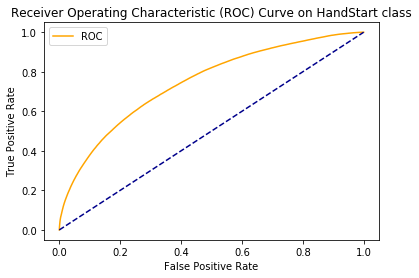

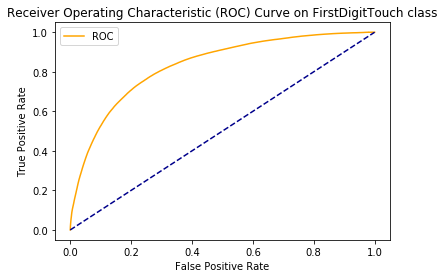

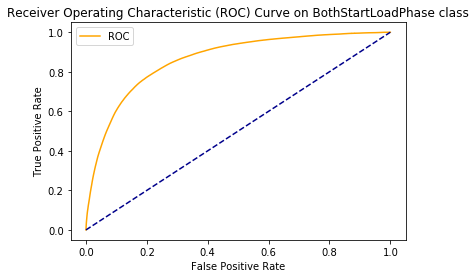

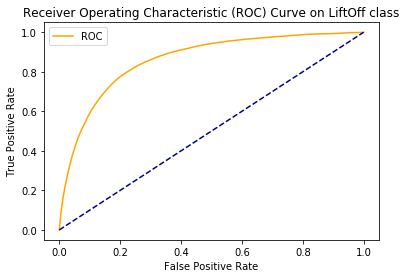

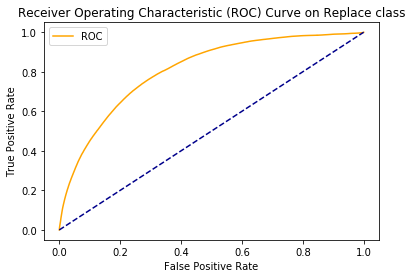

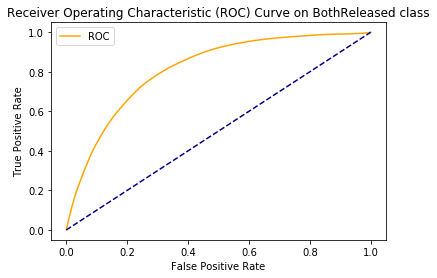

In [0]:
for j in range(6):
    fpr, tpr, thresholds = roc_curve(test_targs[:, j], test_preds[:, j])
    plot_roc_curve(fpr, tpr,str(labels[j]))